In [1]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.datasets import make_regression, make_classification

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
def bootstrap(X, y):
    indexes = np.random.randint(len(X), size=len(X)) 
    return np.array([X[i] for i in indexes]), np.array([y[i] for i in indexes]) 

def random_subspace_method(X, p=1.0):
    X = np.transpose(X)
    return np.transpose(np.array([X[i] for i in range(len(X)) if np.random.random() <= p]))

In [29]:
X = np.arange(16).reshape(4, 4)
y = np.arange(4)

assert type(bootstrap(X, y)[0]) == np.ndarray, "wrong return type of X"
assert type(bootstrap(X, y)[1]) == np.ndarray, "wrong return type of y"
assert bootstrap(X, y)[0].shape == X.shape, "wrong shape of X"
assert bootstrap(X, y)[1].shape == y.shape, "wrong shape of y"

assert type(random_subspace_method(X)) == np.ndarray, "wrong return type"
assert random_subspace_method(X).shape == X.shape, "wrong size"
assert random_subspace_method(X, p=0.5).shape == (4, 2), "wrong size"
assert np.all(np.unique(random_subspace_method(X)) == np.unique(X)), "duplicating features (or smth even worse)"

In [35]:
class BrandNewRandomForestClassifier(BaseEstimator):
    def __init__(self, num_iterations=100, max_depth=6):
        self.num_iterations = num_iterations
        self.max_depth = max_depth
        
    def fit(self, X, y):
        self.estimators = []
        for iter_num in range(self.num_iterations):
            # BEGIN OF YOUR CODE
            X_iter, y_iter = bootstrap(random_subspace_method(X, 1), y)
            
            new_estimator = DecisionTreeClassifier(max_depth=self.max_depth)
            new_estimator.fit(X_iter, y_iter)
            
            # END OF YOUR CODE
            
            self.estimators.append(new_estimator)
            
    def predict_proba(self, X):
        probas = []
        
        for estimator in self.estimators:
            probas.append(estimator.predict_proba(X))
        
        return np.dstack(probas).mean(axis=2)

In [31]:
from sklearn.datasets import make_classification

X, y = make_classification()
np.mean(cross_val_score(DecisionTreeClassifier(max_depth=6), X, y, cv=3, scoring='neg_log_loss'))

-4.5713086405028855

In [36]:
np.mean(cross_val_score(BrandNewRandomForestClassifier(max_depth=6), X, y, cv=3, scoring='neg_log_loss'))

-0.3053392529703679

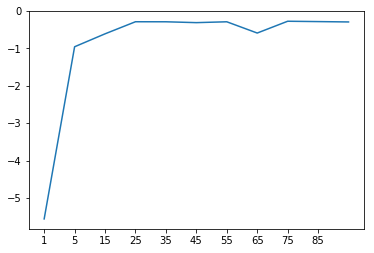

In [37]:
scores = []
for iterations in [1] + range(5, 100, 10):
    algo = BrandNewRandomForestClassifier(num_iterations=iterations)
    scores.append(cross_val_score(algo, X, y, cv=3, scoring='neg_log_loss').mean())
plt.plot(scores)
_ = plt.xticks(range(10), [1] + range(5, 100, 10))

In [43]:
class SimpleGBRegressor(BaseEstimator):
    def __init__(self, num_iterations=100, learning_rate=1e-1, max_depth=6):
        self.num_iterations = num_iterations
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        
    def fit(self, X, y):
        self.estimators = []
        curr_pred = np.zeros(y.shape)
        for iter_num in range(self.num_iterations):
            new_estimator = DecisionTreeRegressor(max_depth=self.max_depth)
            new_estimator.fit(X, y-curr_pred)
            self.estimators.append(new_estimator)
            curr_pred += self.learning_rate*new_estimator.predict(X)
    
    def predict(self, X):
        res = np.zeros(X.shape[0])
        for estimator in self.estimators:
            res += self.learning_rate * estimator.predict(X)
        return res

In [39]:
X_data, y_data = make_regression(n_samples=1000, noise=100, n_features=10, random_state=42)
np.mean(cross_val_score(DecisionTreeRegressor(max_depth=6), X_data, y_data, cv=3, scoring='neg_mean_squared_error'))

-19074.43246352996

In [44]:
algo = SimpleGBRegressor(num_iterations=50, learning_rate = 0.1, max_depth=6)
np.mean(cross_val_score(algo, X_data, y_data, cv=3, scoring='neg_mean_squared_error'))

-12380.26286301332

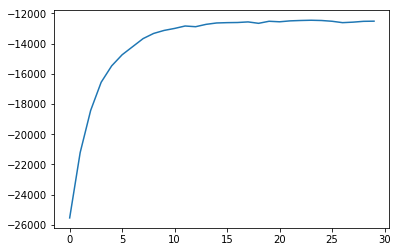

In [45]:
scores = []
for iterations in range(30):
    algo = SimpleGBRegressor(num_iterations=iterations, learning_rate=0.2)
    scores.append(cross_val_score(algo, X_data, y_data, cv=3, scoring='neg_mean_squared_error').mean())
plt.plot(scores)